In [1]:
import numpy as np
import keras
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = False

DIR = '/home/disij/projects/cifar-10h/data/'

In [8]:
human_counts = np.load(DIR + 'cifar10h-counts.npy')
s_human = np.load(DIR + 'cifar10h-probs.npy')
y_human = np.argmax(s_human, axis=1)
array = np.genfromtxt(DIR + 'cifar10_resnet_small_predictions.txt', delimiter=',')
y = array[:, 0].astype(np.int)
s_model = array[:, 1:].astype(np.float)
y_model = np.argmax(s_model, axis=1)

n, k = s_model.shape

# compare y_human, y_model with y (ground truth)

In [3]:
from sklearn.calibration import calibration_curve
NUM_BINS = 6

def _plot(ax, w, mean_predicted_value, fraction_of_positives, num_bins, color, label):
    
    x = [i + 0.5 for i in range(num_bins)]
    
    # ax1.grid(True)
    ax.plot(mean_predicted_value * num_bins, fraction_of_positives, c=color, marker='*', label=label)
    ax.plot(np.linspace(0, 1, num_bins + 1), c="gray")

    ax.set_xlabel("Score(Model Confidence)")
    ax.set_xlim((0.0, num_bins))
    ax.set_xticks(range(num_bins + 1))
    ax.set_xticklabels(["%.2f" % i for i in np.linspace(0, 1, num_bins + 1)])
    ax.set_ylabel("Accuracy")
    ax.set_ylim((0.0, 1.0))
    ax.set_yticks(np.linspace(0, 1, num_bins + 1))
    ax.set_yticklabels(["%.2f" % i for i in np.linspace(0, 1, num_bins + 1)])


    # add histogram to the reliability diagram
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.bar([i + 0.5 for i in range(num_bins)], w, color=color, alpha=0.5, label="Histogram", width=1.0)
    #ax2.set_ylabel('Histogram', color=color)
    ax2.set_ylim((0.0, 2.0))
    ax2.set_yticks([0, 0.5, 1.0])
    ax2.set_yticklabels([0, 0.5, 1.0], color=color, fontsize=3)
    ax2.yaxis.set_label_coords(1.01, 0.25)
    
    return ax

def plot_reliability_diagram(ax, s, y):
    
    num_bins = NUM_BINS
    y_pred = np.argmax(s, axis=1)
    s_max = np.max(s, axis=1)
    correctness = y==y_pred
    fraction_of_positives, mean_predicted_value = calibration_curve(correctness, s_max, n_bins=num_bins)
    hist, edges = np.histogram(s_max, bins=num_bins, range=(0, 1), density=False)
    w = hist * 1.0 / hist.sum()
    
    ax = _plot(ax, w, mean_predicted_value, fraction_of_positives, num_bins, color='r', label='binary label')
    ax.annotate('acc = %.1f%%\nscore=%.2f' % (100*(correctness).mean(), s_max.mean()), 
                            xy=(0.4, 0.2), xycoords='axes fraction', fontsize=12,
                            ha='left', va='top', color='r')
    
    return ax

def plot_reliability_diagram_with_soft_labels(ax, s, y_dist):
    
    num_bins = NUM_BINS
    num_samples = s.shape[0]
    y_pred = np.argmax(s, axis=1)
    s_max = np.max(s, axis=1)
    correctness = y_dist[np.arange(num_samples), y_pred]
    # compute fraction_of_positives, mean_predicted_value 
    fraction_of_positives = np.zeros((num_bins,))
    mean_predicted_value = np.zeros((num_bins,))
    bins = np.linspace(0, 1, num_bins + 1)
    categories = np.digitize(s_max, bins[1:-1]).astype(int)
    for i in range(num_bins):
        mean_predicted_value[i] = s_max[categories==i].mean()
        fraction_of_positives[i] = correctness[categories==i].mean()
    
    hist, edges = np.histogram(s_max, bins=num_bins, range=(0, 1), density=False)
    w = hist * 1.0 / hist.sum()
    
    ax = _plot(ax, w, mean_predicted_value, fraction_of_positives, num_bins, color='b', label='soft human label')
    ax.annotate('acc = %.1f%%\nscore=%.2f' % (100*(correctness).mean(),
                                              s_max.mean()), 
                            xy=(0.1, 0.7), xycoords='axes fraction', fontsize=12,
                            ha='left', va='top', color='b')
    
    return ax

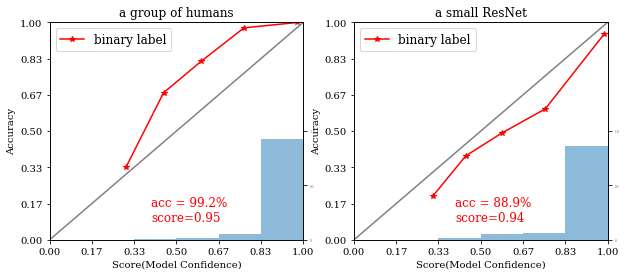

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1 = plot_reliability_diagram(ax1, s_human, y)
ax1.set_title('a group of humans', fontsize=12)
ax2 = plot_reliability_diagram(ax2, s_model, y)
ax2.set_title('a small ResNet', fontsize=12)

ax1.legend(fontsize=12)
ax2.legend(fontsize=12)

# compare y_human, y_model

/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.


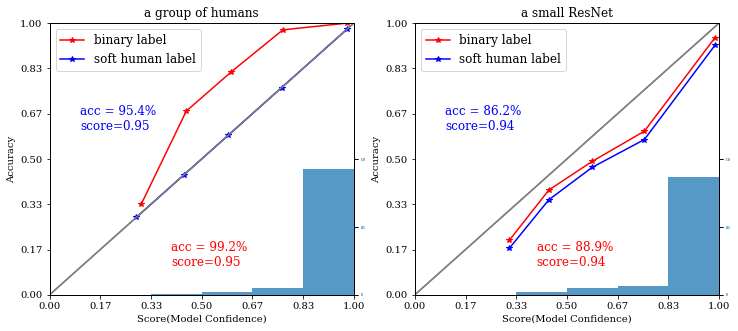

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1 = plot_reliability_diagram(ax1, dataset.s_human, dataset.y)
ax1.set_title('a group of humans', fontsize=12)
ax2 = plot_reliability_diagram(ax2, dataset.s_model, y)
ax2.set_title('a small ResNet', fontsize=12)

ax1 = plot_reliability_diagram_with_soft_labels(ax1, dataset.s_human, dataset.s_human)
ax1.set_title('a group of humans', fontsize=12)
ax2 = plot_reliability_diagram_with_soft_labels(ax2, dataset.s_model, dataset.s_human)
ax2.set_title('a small ResNet', fontsize=12)

ax1.legend(fontsize=12, loc = 'upper left')
ax2.legend(fontsize=12, loc = 'upper left')

- to explain the figure above
    1. true calibration and accuracy is worst than current estimates? because the randomness of y|x is ignored with binary label?
    2. for the figure on the left: the binary labels itself is an overocnfident estimation of true labels  => 1
    3. should ground truth (binary labels) of examples be considered as samples from true label distributions or the consensus of a group of humans? 
- calibrate model scores to human uncertainty
- how useful is the vector of scores that a model generates?
- calibrate to human label distributions?

# accuracy estimation with more samples from p(y|x)

In [6]:
def sample_prediction_counts(y_counts): # draw one label for each sample
    sampled_y_counts = np.zeros(y_counts.shape)
    n, k = y_counts.shape
    
    assert np.sum(y_counts, axis=1).min() >= 1
    samples = np.array([np.random.choice(k, 1, p= y_counts[i]/y_counts[i].sum())[0] for i in range(n)])
    sampled_y_counts[np.arange(n), samples] += 1
    y_counts[np.arange(n), samples] -= 1
    
    return sampled_y_counts, y_counts

In [9]:
# sample labels points
num_runs = 50
num_labelers = 47
sampled_human_labels = np.zeros((num_runs, num_labelers, n, k))
for r in range(num_runs):
    pool_of_human_labels = np.load(DIR + 'cifar10h-counts.npy')
    for i in range(num_labelers):
        sampled_human_labels[r, i], pool_of_human_labels = sample_prediction_counts(pool_of_human_labels)

In [10]:
# accuracy
acc = np.zeros((num_runs, num_labelers))
for r in tqdm(range(num_runs)):
    human_labels = np.zeros(human_counts.shape)
    for i in range(num_labelers):
        human_labels += sampled_human_labels[r, i]
        y_pred = np.argmax(human_labels, axis=1)
        acc[r,i] = (y_pred == y).mean()

100%|██████████| 50/50 [00:00<00:00, 75.53it/s]


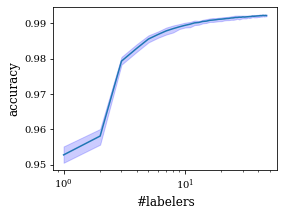

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(range(1, num_labelers+1), np.mean(acc, axis=0))
ax.fill_between(range(1, num_labelers+1), 
                np.quantile(acc, 0.125, axis=0), 
                np.quantile(acc, 0.875, axis=0), 
                color='blue', alpha=.2)
ax.set_xlabel('#labelers', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)
ax.set_xscale('log')

# accuracy estimation with more samples from p(x)

In [51]:
# sample labels points
num_runs = 50
num_samples = n
acc_soft_prediction = np.zeros((num_runs, num_samples))
acc_hard_prediction = np.zeros((num_runs, num_samples))

s = s_human[np.arange(num_samples), y]
for r in range(num_runs):
    idx = np.arange(n)
    np.random.shuffle(idx, )
    for i in range(num_samples):
        acc_soft_prediction[r,i] = s[idx[:i]].mean()
        acc_hard_prediction[r,i] = (y_human == y)[idx[:i]].mean()

/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]


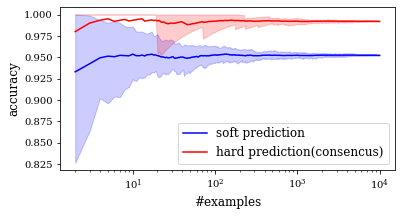

In [52]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(1, num_samples+1), np.mean(acc_soft_prediction, axis=0), color='blue', label='soft prediction')
ax.fill_between(range(1, num_samples+1), 
                np.quantile(acc_soft_prediction, 0.125, axis=0), 
                np.quantile(acc_soft_prediction, 0.875, axis=0), 
                color='blue', alpha=.2)
ax.plot(range(1, num_samples+1), np.mean(acc_hard_prediction, axis=0), color='red', label='hard prediction(consencus)')
ax.fill_between(range(1, num_samples+1), 
                np.quantile(acc_hard_prediction, 0.125, axis=0), 
                np.quantile(acc_hard_prediction, 0.875, axis=0), 
                color='red', alpha=.2)
ax.set_xlabel('#examples', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)
ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize=12)


    red curve is above the blue curve because ground truth labels of cifar10 is created with cencensus of multiple labelers, i.e. the red curve always converges to ～100%. 

In [252]:
from torch import nn, optim
import torch
from torch.nn import functional as F

class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Expand temperature to match the size of logits
        logits = torch.tensor(logits).cuda()
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, logits, labels):
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        with torch.no_grad():
            logits = torch.tensor(logits).cuda()
            labels = torch.tensor(labels).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=100)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self
    
    
class TemperatureScalingSoftLabels(TemperatureScaling):
    def set_temperature(self, logits, labels):
        self.cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        with torch.no_grad():
            logits = torch.tensor(logits).cuda()
            labels = torch.tensor(labels).cuda()

#         # Calculate NLL and ECE before temperature scaling
#         before_temperature_nll = nll_criterion(logits, labels).item()
#         before_temperature_ece = ece_criterion(logits, labels).item()
#         print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=100)

        def eval():
            probs = F.softmax(self.temperature_scale(logits))
            loss = (torch.log(probs) * labels).sum()
            loss.backward()
            return loss
        
        optimizer.step(eval)

#         # Calculate NLL and ECE after temperature scaling
#         after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
#         after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
#         print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self

class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [253]:
from scipy.special import softmax

class Dataset:
    def __init__(self,
                 y: np.ndarray,
                 human_counts: np.ndarray,
                 s_human: np.ndarray,
                 logits_model: np.ndarray,
                 dataset_name: str) -> None:
        self.y = y
        self.human_counts = human_counts
        self.s_human = s_human
        self.logits_model = logits_model
        self.s_model = softmax(logits_model, axis=1)
        self.y_human = np.argmax(s_human, axis=1)
        self.y_model = np.argmax(s_model, axis=1)
        self._add_information(dataset_name)
        
    
    def _add_information(self, dataset_name):
        self.dataset_name = dataset_name
        self.n, self.k = self.s_model.shape
        self.indices = np.arange(self.n)
        
        
    def shuffle(self, random_state=0) -> None:
        shuffle_ids = np.arange(self.n)
        shuffle_ids = shuffle(shuffle_ids, random_state=random_state)
        self.y = self.y[shuffle_ids]
        self.human_counts = self.human_counts[shuffle_ids]
        self.s_human = self.s_human[shuffle_ids]
        self.s_model = self.s_model[shuffle_ids]
        self.indices = self.indices[shuffle_ids]
        self.y_human = self.y_human[shuffle_ids]
        self.y_model = self.y_model[shuffle_ids]
        
    @classmethod
    def load_from_text(cls, dataset_name: str) -> 'Dataset':
        if dataset_name == 'cifar10':
            human_counts = np.load(DIR + 'cifar10h-counts.npy')
            s_human = np.load(DIR + 'cifar10h-probs.npy')
            
            array = np.genfromtxt(DIR + 'cifar10_resnet_small_logits.txt', delimiter=',')
            logits_model = array[:, 1:].astype(np.float)
            y = array[:, 0].astype(np.int)
  
        return cls(y, human_counts, s_human, logits_model, dataset_name)

    def calibration(self, calibration_type):
        if calibration_type == 'temperature_scaling':
            print('Training and apply temperature scaling to model predictor...')
            temperature_model = TemperatureScaling()
            temperature_model.set_temperature(self.logits_model, self.y)
            self.calibrated_logits_model = temperature_model(self.logits_model).cpu().data.numpy() 
            self.calibrated_s_model = softmax(self.calibrated_logits_model, axis=1)
            
            print('\nTraining and apply temperature scaling to human predictor...')
            temperature_model = TemperatureScaling()
            temperature_model.set_temperature(np.log(self.s_human+1e-10), self.y)
            self.calibrated_logits_human = temperature_model(np.log(self.s_human)).cpu().data.numpy() 
            self.calibrated_s_human = softmax(self.calibrated_logits_human, axis=1)

            
    def calibration_to_distribution(self, calibration_type):
        if calibration_type == 'temperature_scaling':
            print('Training and apply temperature scaling to model predictor...')
            temperature_model = TemperatureScalingSoftLabels()
            temperature_model.set_temperature(self.logits_model, self.s_human)
            self.calibrated_logits_model = temperature_model(self.logits_model).cpu().data.numpy() 
            self.calibrated_s_model = softmax(self.calibrated_logits_model, axis=1)
            
            print('\nTraining and apply temperature scaling to human predictor...')
            temperature_model = TemperatureScalingSoftLabels()
            temperature_model.set_temperature(np.log(self.s_human+1e-10), self.s_human)
            self.calibrated_logits_human = temperature_model(np.log(self.s_human)).cpu().data.numpy() 
            self.calibrated_s_human = softmax(self.calibrated_logits_human, axis=1)

In [256]:
dataset = Dataset.load_from_text('cifar10')
#dataset.calibration('temperature_scaling')
dataset.calibration_to_distribution('temperature_scaling')

Training and apply temperature scaling to model predictor...
Optimal temperature: -48.607

Training and apply temperature scaling to human predictor...
Optimal temperature: 2180.914


/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.


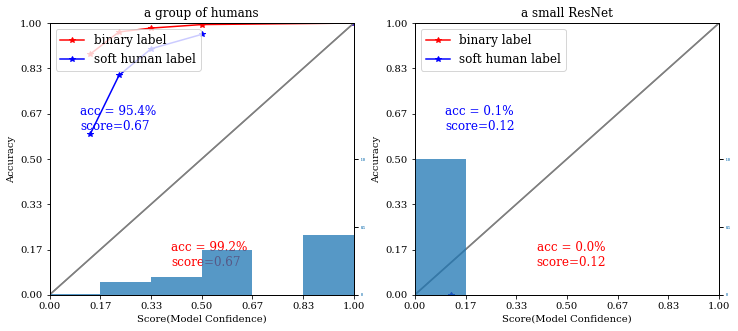

In [257]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1 = plot_reliability_diagram(ax1, dataset.calibrated_s_human, dataset.y)
ax1.set_title('a group of humans', fontsize=12)
ax2 = plot_reliability_diagram(ax2, dataset.calibrated_s_model, y)
ax2.set_title('a small ResNet', fontsize=12)

ax1 = plot_reliability_diagram_with_soft_labels(ax1, dataset.calibrated_s_human, dataset.s_human)
ax1.set_title('a group of humans', fontsize=12)
ax2 = plot_reliability_diagram_with_soft_labels(ax2, dataset.calibrated_s_model, dataset.s_human)
ax2.set_title('a small ResNet', fontsize=12)

ax1.legend(fontsize=12, loc = 'upper left')
ax2.legend(fontsize=12, loc = 'upper left')


In [189]:
len(dataset.y.shape)

1